<a href="https://colab.research.google.com/github/knoeferl/mi_seminar_uebung/blob/main/uebung_Aktivtaetserkennung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Übungen Aktivtätserkennung von Michael Knöferl

In folgender Übung sollt ihr die Inhalte aus des Vortargs selbst nachstellen können.

Ihr könnt links über Inhalt zu den einzelenen Übungen gehen.
Das erste Stück ist zur installation benötigten Software auf der Instance.


Clone Github Repo

In [ ]:
from IPython.display import clear_output
%cd /content/
!git clone -l -s git://github.com/knoeferl/mi_seminar_uebung.git mi_seminar_uebung
%cd /content/mi_seminar_uebung
!ls
clear_output()

Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext
from IPython.display import clear_output

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  !apt-get update
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
clear_output()


In [ ]:
!pip3 install torch torchvision
!pip3 install torchnet
clear_output()

Intalling ffmpeg in new version for AV1 codec of Youtube

In [ ]:
!git clone https://github.com/rokibulislaam/colab-ffmpeg-cuda.git
!cp -r ./colab-ffmpeg-cuda/bin/. /usr/bin/
!ffmpeg -version
clear_output()

Download alternativ Dataset

In [ ]:
# from IPython.display import clear_output
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Cq-kw9XDiPYURfTS14FUE8lo0ka4HR-k' -O mydataset.h5
# clear_output()

In [ ]:
import os
import numpy as np
import h5py
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
use_cuda = torch.cuda.is_available()
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
import torchvision.models.inception as inception



use cuda: True


Datensatz laden

Wie im Vortrag erwähnt besteht der Datensatz das die bereits mit Openpose vor verarbeitet wurden und die entsprechenden Features wurde bereits extrahiert.

Es sind 3 Features pro Bild für 15 Bilder und wir laden immer 15 Stück als ein Batch ein.

Beim Laden werden die Daten gleich in einen Trainings- und einen Validierungsdatensatz aufgeteilt

In [ ]:
class Dataset(DD.Dataset):
    def __init__(self, data_path, name='dataset'):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, '%s.h5'%name)

        with h5py.File(self.data_path) as f:
            self.data = np.array(f['seq'])
            self.label = np.array(f['label'])

        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        label = int(self.label[index])
        sample = {'seq': seq, 'label': label}
        return sample

    def __len__(self):
        return self.num_sequences


dataset = Dataset('./', name='mydataset')
batch_size = 15
validation_split = .2
shuffle_dataset = True
random_seed= 42


dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trLD = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                   sampler=train_sampler)
valLD = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                    sampler=valid_sampler)
input_dim = dataset.n_dim
num_class = 4
dim = batch_size * dataset.n_dim

Anzahl der Features

In [ ]:
print(dataset.n_dim)

45


Länge einer Sequenzen

In [ ]:
print(dataset.seq_len)

15


Anzahl der Sequenzen

In [ ]:
print(dataset.num_sequences)

995


#Long Short Term Memory

## Aufgabe 1: Schreibe ein LSTM

Im durch Kommentare gekennzeichneten Bereich schreibe ein Aufruf für die LSTM Funktion von Pytorch.

Doku LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

Ihr könnte hier mit der Anzahl der Hiddenlayer Spielen und sehen wie sich die Resultate verändern.
Die Anzahl der Hiddenlayer muss bei der Linear Funktion als erster Parameter mit hinein geben werden.

Doku LINEAR: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html


In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)

class SequenceClassify(nn.Module):
    def __init__(self, dim, batch_size):
        super(SequenceClassify, self).__init__()
        ##################Aufgabe 1##################
        self.recurrent_layer = #LSTM hier hin
        self.project_layer = nn.Linear(14, num_class)
        #############################################
    def forward(self, input1, h_t_1=None, c_t_1=None):
        lstm_input = input1
        rnn_outputs, (hn, cn) = self.recurrent_layer(lstm_input)        
        logits = self.project_layer(rnn_outputs[:,-1])
        return logits
    
model = SequenceClassify(dim, batch_size)    
if torch.cuda.is_available():
  model = SequenceClassify(dim, batch_size).cuda()



**Optimizer wahl**

Hier könnt ihr verschieden Optimizer testen.
Dies ist zwar kein bestandtteil der Präsentation gewesen aber vielleicht doch für den einen oder anderen interessant.

In [ ]:
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
optimizer = torch.optim.Adadelta(model.parameters(), lr = 1e-1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

## Aufgabe 2: LSTM laufen lassen
Hier könnt ihr die Anzahl der Epochen verändern und in den nachfolgenden Cellen betrachten wie sich die Resultate verändern.

In [ ]:
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)
        output_logits = model(input_sequence_var)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.item())
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)
    if logger_prefix == 'val':
        val_loss.append(meter_loss.value()[0])
        val_accuracy.append(acc.value()[0])
    else:
        train_loss.append(meter_loss.value()[0])
        train_accuracy.append(acc.value()[0])
    return acc.value()[0]

global val_loss, val_accuracy, train_loss, train_accuracy, num_epochs
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []

##################Aufgabe 2##################
num_epochs = 501
#############################################
evaluate_every_epoch = 1

for e in range(num_epochs):
    print("Epoche " + str(e) + " of " + str(num_epochs))
    run_epoch(trLD, model, criterion, e, True, optimizer)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, model, criterion, e, False, None)   

PATH = "/content/mi_seminar_uebung/model.pth"
torch.save(model.state_dict(), PATH)

clear_output()

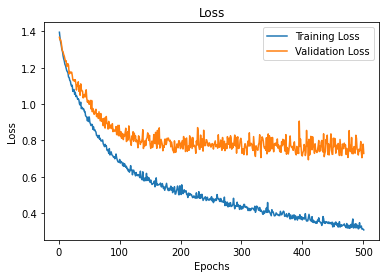

In [ ]:
epochs = []
for i in range(1, num_epochs+1):
    epochs.append(i)
import matplotlib.pyplot as plt
%matplotlib inline
plot1 = plt.plot(epochs, train_loss)
plot2 = plt.plot(epochs, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend(["Training Loss", "Validation Loss"], loc = 1)
plt.show()

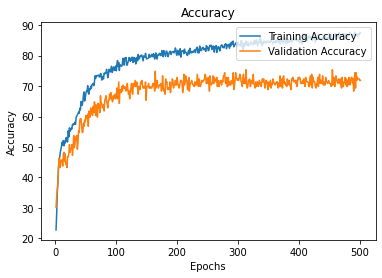

In [ ]:
epochs = []
for i in range(1, len(train_accuracy)+1):
    epochs.append(i)
plot3 = plt.plot(epochs, train_accuracy)
plot4 = plt.plot(epochs, val_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"], loc = 1)
plt.show()

/content/mi_seminar_uebung


<Figure size 720x720 with 0 Axes>

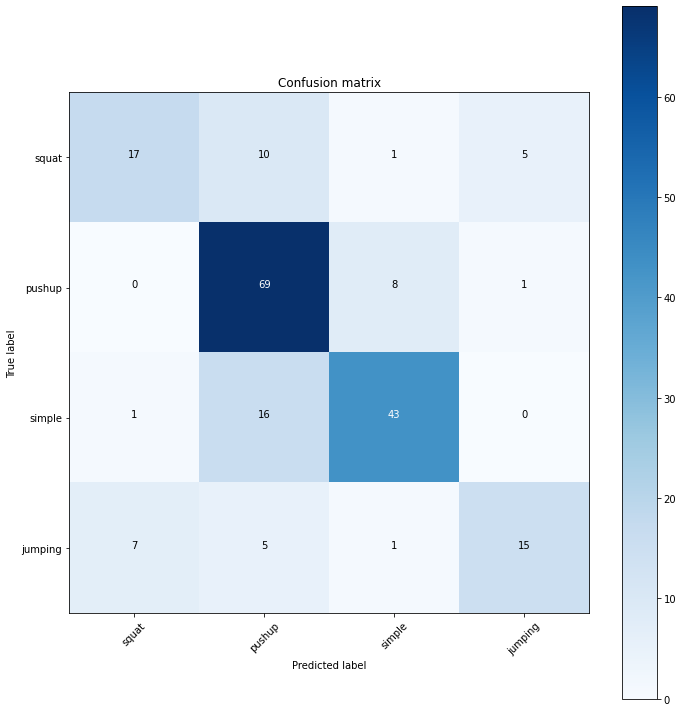

<Figure size 720x720 with 0 Axes>

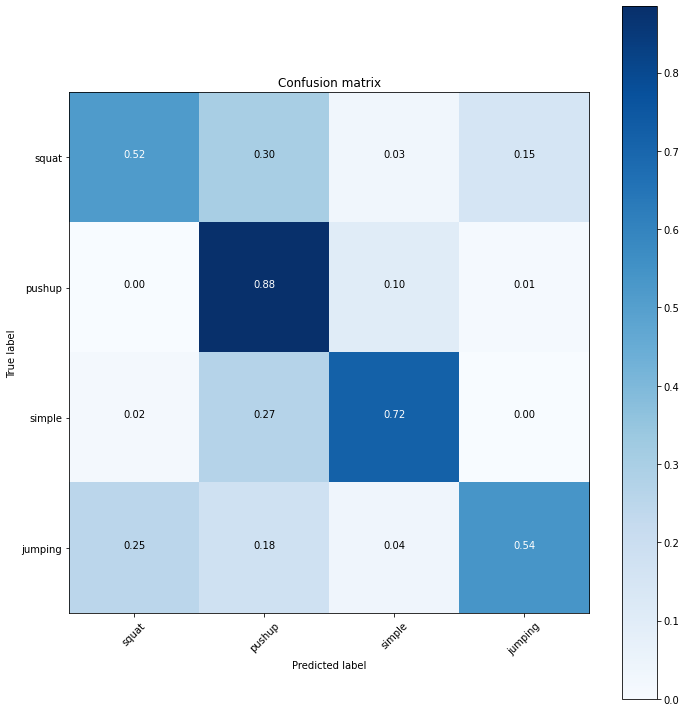

In [ ]:
%cd /content/mi_seminar_uebung
import itertools
import numpy as np
import matplotlib.pyplot as plt
from helper import plot_confusion_matrix

def predict_on_test(model, data_loader):
    model.eval() # Model wird in evaluierungs modus gebracht
    results=open("results.csv",'w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    all_preds = list()
    all_labels = list()
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        all_preds = np.append(all_preds, preds.cpu())
        all_labels = np.append(all_labels, label)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i])+'\n')
            count+=1
    results.close()
 
    all_preds = torch.from_numpy(all_preds.astype(int))
    all_labels = torch.from_numpy(all_labels.astype(int))
    stacked = torch.stack((all_labels, all_preds), dim=1 )

    cmt = torch.zeros(4,4, dtype=torch.int64)
    for p in stacked:
      tl, pl = p.tolist()
      cmt[tl, pl] = cmt[tl, pl] + 1
    return cmt



cm = predict_on_test(model, valLD)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, ['squat', 'pushup', 'simple', 'jumping'])
print()
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, ['squat', 'pushup', 'simple', 'jumping'], normalize=True)

In [ ]:
div_labels = {}

for sample in dataset:
  labeling = sample['label']
  if labeling in div_labels:
    div_labels[labeling] = div_labels[labeling] + 1
  else:
    div_labels[labeling] = 0

print(div_labels)

{3: 135, 1: 407, 2: 316, 0: 133}


Action Erkännung an Hand eines Youtubevideos

Video wird an hand der ID bestimmt

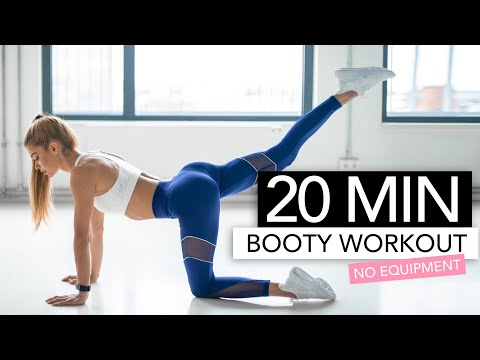

In [ ]:
from IPython.display import YouTubeVideo
YOUTUBE_ID = 'HeolReSa5ic'
YouTubeVideo(YOUTUBE_ID)

Youtubevideo wird heruntergeladen und die interessante Stelle herausgeschnitten.
In diesem Beispiel, ab 12:09 Min bis 12:16 Min

In [ ]:
if not exists('/content/mi_seminar_uebung/temp/video.mp4'):
  !rm -rf /content/mi_seminar_uebung/temp/youtube.mp4
  !youtube-dl -f 'bestvideo[ext=mp4]' --output "/content/mi_seminar_uebung/temp/youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
  !ffmpeg -y -loglevel info  -i /content/mi_seminar_uebung/temp/youtube.mp4 -ss 00:12:09 -t 00:00:07 -c:v copy -c:a copy /content/mi_seminar_uebung/temp/video.mp4
clear_output()

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('/content/mi_seminar_uebung/temp/video.mp4', width=960, height=720)


Openpose erstellt json files mit den erkannten Informationen und erstellt ein Video in dem diese dargestellt werden.

In [ ]:
if True:
  !ffmpeg -y -loglevel info -i /content/mi_seminar_uebung/temp/video.mp4 /content/mi_seminar_uebung/openpose/examples/media/video.avi 

  !rm /content/mi_seminar_uebung/temp/openpose.avi
  !rm /content/mi_seminar_uebung/temp/output/*
  !cd /content/mi_seminar_uebung/openpose && ./build/examples/openpose/openpose.bin --video examples/media/video.avi --write_json /content/mi_seminar_uebung/temp/output/ --display 0 --write_video /content/mi_seminar_uebung/temp/openpose.avi --face --hand

  import subprocess
  video_input = 'examples/media/video.mp4'
  json_folder = '/content/mi_seminar_uebung/temp/output/'
  avi_ = "/content/mi_seminar_uebung/temp/openpose.avi"

  !ffmpeg -y -loglevel info -i /content/mi_seminar_uebung/temp/openpose.avi /content/mi_seminar_uebung/temp/output.mp4
  clear_output()

## Aufgabe 3: Features berechnen

### a) schreibe die Funktion calc_angle welche die Winkelveränderung zwischen zwei Bildern zurück gibt

### b) schreibe die Funktion calc_euclidan welche den Euklisichen Abstand zwischen zwei Punkten zurück gibt

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
from extract_features import create_json_and_mp4
from helper import ReadFromVideo, VideoWriter, ImageDisplayer, draw_scores_onto_image
import json

class Dataset(DD.Dataset):
    def __init__(self, data):
        super(Dataset, self).__init__()

        self.data = np.array(data)
        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        return seq

    def __len__(self):
        return self.num_sequences


def calc_angele(vector_1, vector_2):
    if (vector_1[1] == vector_2[1]) and (vector_2[0] == vector_1[0]):
        return 0.0
    ##################Aufgabe 3 a) ##################
    return #
    #################################################

def calc_euclidan(vector_1, vector_2):
  
  ##################Aufgabe 3 b) ##################
  return #
  #################################################

def preapareDataOfFolder(path_to_folder):
    if os.path.exists(path_to_folder):
        json_files = [pos_json for pos_json in os.listdir(path_to_folder) if pos_json.endswith('.json')]
        if len(json_files) == 0:
            return []
        print('Found: ', len(json_files), 'json keypoint frame files')
        print('json files: ', json_files[0])
        elements = json_files[0].split('_')
        nameLabel = '_'.join(elements[0:2])
        label = elements[2]
        batch_size = 15

        sequence = []
        result = []

        for fileNum in range(len(json_files) - 1):
            try:
                temp_df1 = json.load(open(path_to_folder + json_files[fileNum]))
                temp_df2 = json.load(open(path_to_folder + json_files[fileNum + 1]))
            except Exception:
                print(path_to_folder + json_files[fileNum])
                continue

            try:
                np_v = np.array(temp_df1['people'][0]['pose_keypoints_2d'])
            except Exception:
                result.append(result[-1])
                continue
            np_v_reshape = np_v.reshape(int(len(np_v) / 3), 3)
            try:
                np_v2 = np.array(temp_df2['people'][0]['pose_keypoints_2d'])
            except Exception:
                if np_v is not None:
                    np_v2 = np_v
                else:
                    result.append(result[-1])
                 
                    continue
            np_v_reshape2 = np_v2.reshape(int(len(np_v2) / 3), 3)
            features = []

            # Über die 15 Punkte des aktuellen und des nächsten Frames gehen, hierbei Abstand, Winkel und Erwartungswert berechenen
            for i in range(15):
                point1 = np.array([np_v_reshape[i][0], np_v_reshape[i][1]])
                point2 = np.array([np_v_reshape2[i][0], np_v_reshape2[i][1]])

                distance = calc_euclidan(point1, point2)
                angle = calc_angele(point1, point2)
                probability = (np_v_reshape[i][2] + np_v_reshape2[i][2]) / 2

                features.append(float(distance))
                features.append(float(angle))
                features.append(float(probability))
            sequence.append(features)
            if len(sequence) >= batch_size:
                result.append(sequence)
                sequence = []
               
        if len(sequence) > 0:
            number_of_zero_features = batch_size - len(sequence)
            for n in range(number_of_zero_features):
                shape = len(sequence[0])
                zeros = []
                for t in range(shape):
                    zeros.append(.0)
                sequence.append(zeros)
            result.append(sequence)

    else:
        print(path_to_folder + " not found")

    return result

num_class = 4

PATH = "/content/mi_seminar_uebung/model.pth"

use_cuda = torch.cuda.is_available()
print('use cuda: %s' % (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

batch_size = 15
dim = 675
model = SequenceClassify(dim, batch_size)
if use_cuda:
    model.cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

filename = 'video_out.avi'
mp4_file = '/content/mi_seminar_uebung/temp/openpose.avi'
json_folder = '/content/mi_seminar_uebung/temp/output/'

result = preapareDataOfFolder(json_folder)

#label wird hier von überschrieben da im orginal da das Youtube video nicht den Namenskonventionen entspricht
label_list = ['squat', 'pushup', 'simple', 'jumping']
dataset = Dataset(result)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

images_loader = ReadFromVideo(mp4_file)


DST_FOLDER = '/content/mi_seminar_uebung/temp/'
DST_VIDEO_NAME = filename
DST_VIDEO_FPS = images_loader.get_fps()

video_writer = VideoWriter(DST_FOLDER + DST_VIDEO_NAME, DST_VIDEO_FPS)

all_scores = []
for batch_idx, sample in enumerate(data_loader):
    input_sequence_var = Variable(sample).type(FloatTensor)
    scores = model(input_sequence_var)
    # Wie im Vortrag beschrieben berechnet Softmax die entsprechenden Warscheinlichkeiten für die scores
    sm = torch.nn.Softmax(dim=1)
    probabilities = sm(scores)
    all_scores.append(probabilities)


try:
    ith_img = -1
    while images_loader.has_image():
        img = images_loader.read_image()
        ith_img += 1
        img_disp = img.copy()
        draw_scores_onto_image(img_disp, all_scores[int(ith_img / (DST_VIDEO_FPS * batch_size))][
            int(ith_img / DST_VIDEO_FPS) % 15],
                               label_list)
        video_writer.write(img_disp)

finally:
    video_writer.stop()
    print("Program ends")

use cuda: True
Found:  164 json keypoint frame files
json files:  video_000000000058_keypoints.json
Complete writing 25.0fps and 6.56s video to /content/mi_seminar_uebung/temp/video_out.avi
Program ends


In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

!ffmpeg -y -loglevel info -i /content/mi_seminar_uebung/temp/video_out.avi /content/mi_seminar_uebung/temp/video_out.mp4
clear_output()
show_local_mp4_video('/content/mi_seminar_uebung/temp/video_out.mp4', width=960, height=720)

#Support Vector Machine


## Aufgabe 4: Ändere den Regulierungsparameter C und betrachte wie sich die Resultate verändern

Doku SVM: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


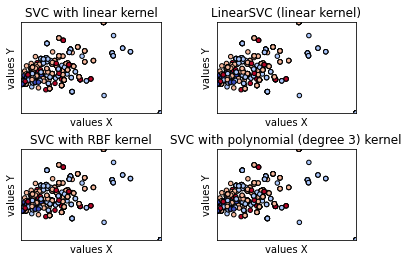

In [ ]:

from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

import itertools
import numpy as np
import matplotlib.pyplot as plt
from helper import plot_confusion_matrix, make_meshgrid, plot_contours


def create_svm_models(dataset_path, C=1.0):
  with h5py.File(dataset_path) as f:
          X = np.array(f['seq'])
          y = np.array(f['label'])

  size = X.shape[0]
  X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)



  models = (svm.SVC(kernel='linear', C=C, max_iter=10000),
            svm.LinearSVC(C=C, max_iter=10000, tol=0.0001),
            svm.SVC(kernel='rbf', gamma=0.7, C=C),
            svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
  models = (clf.fit(X_train, y_train) for clf in models)

  # Title für die Plots
  titles = ('SVC with linear kernel',
            'LinearSVC (linear kernel)',
            'SVC with RBF kernel',
            'SVC with polynomial (degree 3) kernel')
  return models, titles,  X_train, X_test, y_train, y_test

##################Aufgabe 4 ##################
C = 1.0  # SVM regularization parameter
#################################################
models, titles,  X_train, X_test, y_train, y_test = create_svm_models('./mydataset.h5', C)

# 2x2 grid Plot erstellen.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#Daten in Dimension von 675 auf 2 verringern
pca = PCA(n_components=2)
X_r = pca.fit(X_train).transform(X_train)
X0, X1 = X_r[:,0],  X_r[:,1]
xx, yy = make_meshgrid(X0, X1)


for clf, title, ax in zip(models, titles, sub.flatten()):

    model_pred = clf.predict(X_test)

    poly_accuracy = accuracy_score(y_test, model_pred)
    poly_f1 = f1_score(y_test, model_pred, average='weighted')


    ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('values X')
    ax.set_ylabel('values Y')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

    all_preds = torch.from_numpy(model_pred.astype(int))
    all_labels = torch.from_numpy(y_test.astype(int))
    stacked = torch.stack((all_labels, all_preds), dim=1 )

    cmt = torch.zeros(4,4, dtype=torch.int64)
    for p in stacked:
      tl, pl = p.tolist()
      cmt[tl, pl] = cmt[tl, pl] + 1
plt.show()



Accuracy (  SVC with linear kernel  ):  83.92
F1 ( SVC with linear kernel ):  84.42
_________________________________________




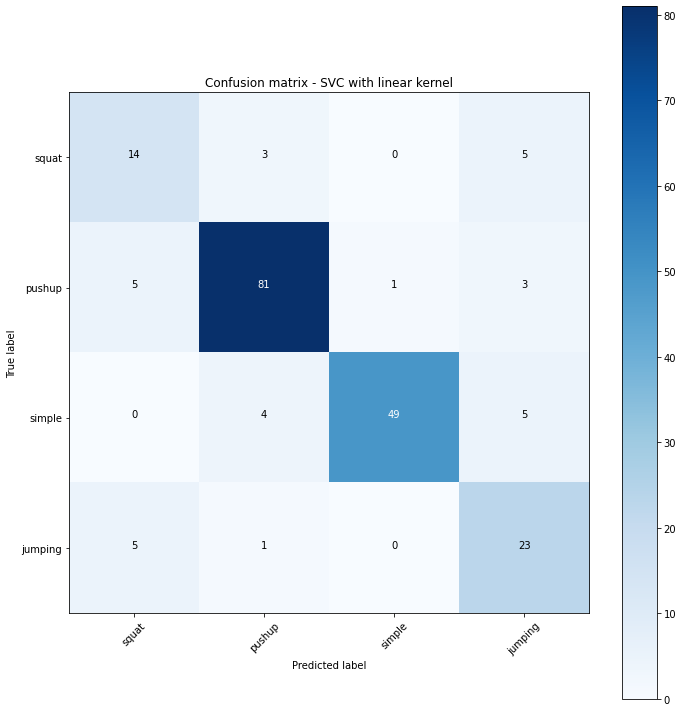

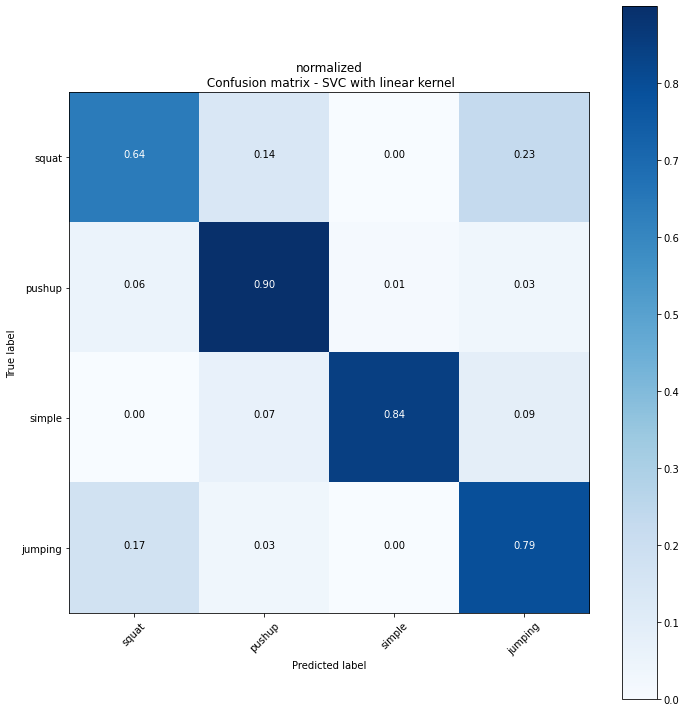

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy (  LinearSVC (linear kernel)  ):  79.90
F1 ( LinearSVC (linear kernel) ):  80.91
_________________________________________




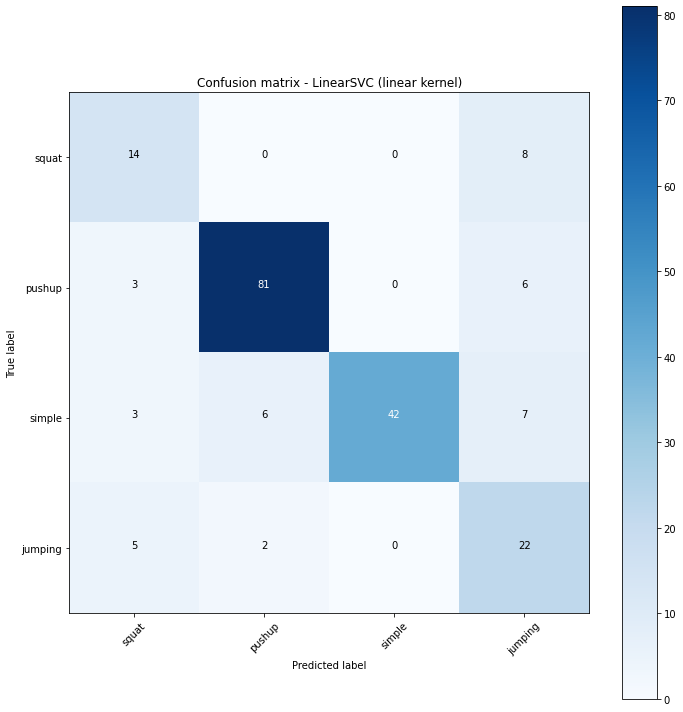

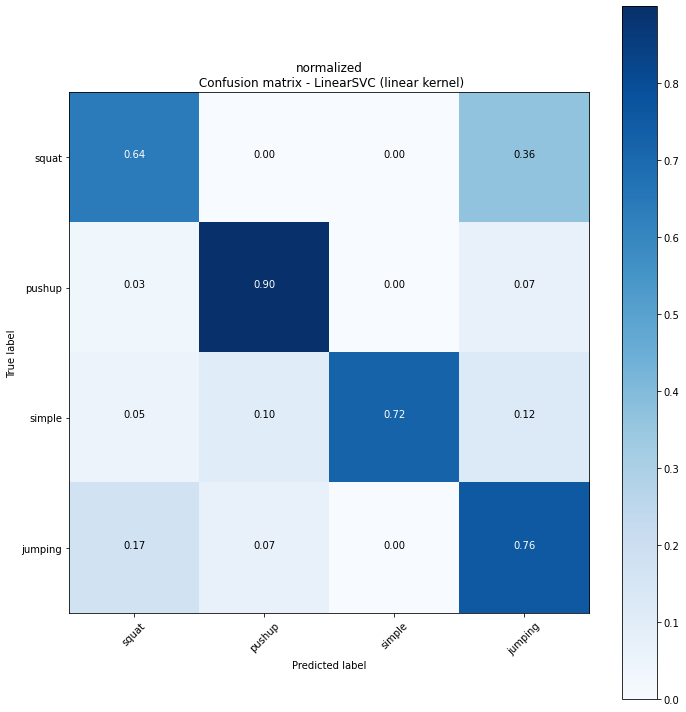

Accuracy (  SVC with RBF kernel  ):  78.89
F1 ( SVC with RBF kernel ):  81.45
_________________________________________




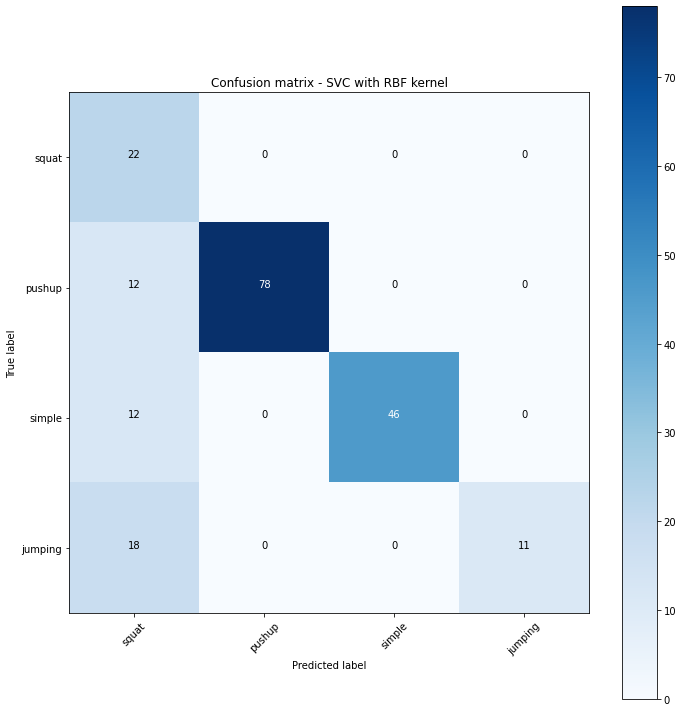

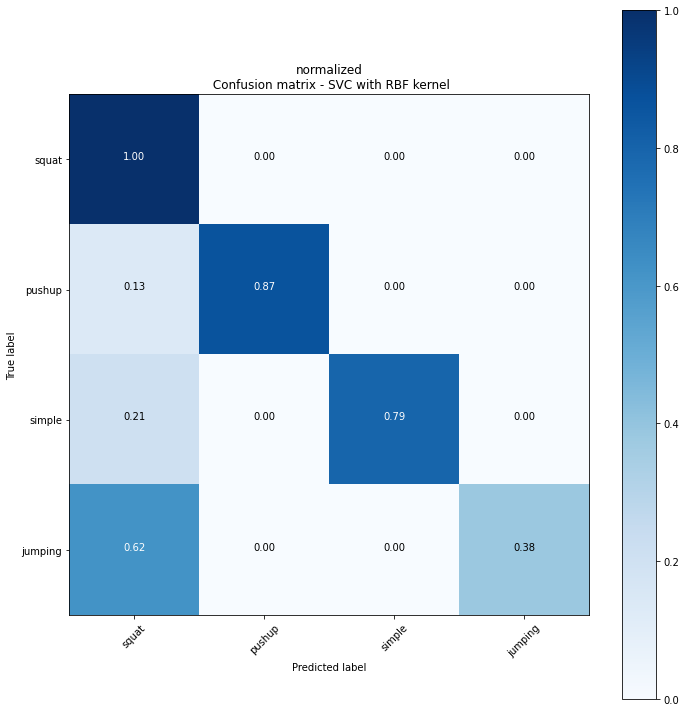

Accuracy (  SVC with polynomial (degree 3) kernel  ):  83.42
F1 ( SVC with polynomial (degree 3) kernel ):  83.59
_________________________________________




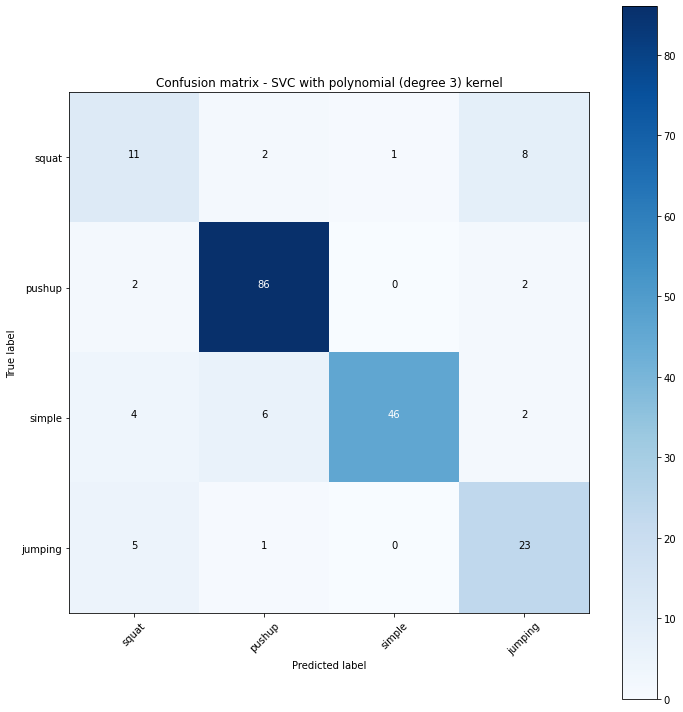

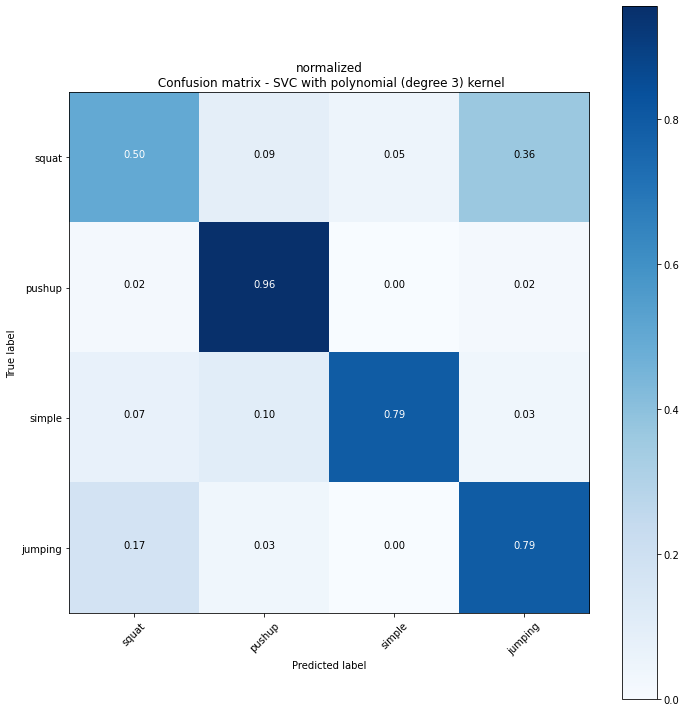

In [ ]:
models, titles,  X_train, X_test, y_train, y_test = create_svm_models('./mydataset.h5', C)

for clf, title in zip(models, titles):
  model_pred = clf.predict(X_test)
  poly_accuracy = accuracy_score(y_test, model_pred)
  poly_f1 = f1_score(y_test, model_pred, average='weighted')
  print('Accuracy ( ', title ,' ): ', "%.2f" % (poly_accuracy*100))
  print('F1 (', title ,'): ', "%.2f" % (poly_f1*100))
  print('_________________________________________\n\n')

  all_preds = torch.from_numpy(model_pred.astype(int))
  all_labels = torch.from_numpy(y_test.astype(int))
  stacked = torch.stack((all_labels, all_preds), dim=1 )

  cmt = torch.zeros(4,4, dtype=torch.int64)
  for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

  plot_confusion_matrix(cmt, ['squat', 'pushup', 'simple', 'jumping'], title='Confusion matrix - ' + title )
  print()
  plot_confusion_matrix(cmt, ['squat', 'pushup', 'simple', 'jumping'], title='normalized\n Confusion matrix - ' + title, normalize=True)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
from extract_features import create_json_and_mp4
from helper import ReadFromVideo, VideoWriter, ImageDisplayer, draw_scores_onto_image
from preprocessing import preapareDataOfFolder
from sklearn import preprocessing

class Dataset(DD.Dataset):
    def __init__(self, data):
        super(Dataset, self).__init__()

        self.data = np.array(data)
        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        return seq

    def __len__(self):
        return self.num_sequences


filename = 'video_out.avi'
mp4_file = '/content/mi_seminar_uebung/temp/openpose.avi'
json_folder = '/content/mi_seminar_uebung/temp/output/'
name_labels = []
labels = []
label_list = []
name_label_list = []
result = []
name_labels, labels, label_list, name_label_list, result = preapareDataOfFolder(json_folder, name_labels, labels,
                                                                                label_list, name_label_list, result)
label_list = ['squat', 'pushup', 'simple', 'jumping']
dataset = Dataset(result)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)


models, titles,  X_train, X_test, y_train, y_test = create_svm_models('./mydataset.h5', C)

result_videos = []
titles = ('linear',
            'LinearSVC',
            'RBF',
            'polynomial')

for clf, title in zip(models, titles):
    images_loader = ReadFromVideo(mp4_file)
    DST_FOLDER = '/content/mi_seminar_uebung/temp/'
    DST_VIDEO_NAME = filename
    DST_VIDEO_FPS = images_loader.get_fps()
    DST_VIDEO_PATH = DST_FOLDER + title + DST_VIDEO_NAME
    video_writer = VideoWriter(DST_VIDEO_PATH, DST_VIDEO_FPS)


    lb = preprocessing.LabelBinarizer()
    lb.fit(range(num_class))

    all_scores = []
    for batch_idx, X in enumerate(data_loader):
        X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
        scores = clf.predict(X)
        labeled_scores = lb.transform(scores.astype(int))
        all_scores.append(labeled_scores)


    try:
        ith_img = -1
        while images_loader.has_image():
            # -- Read image
            img = images_loader.read_image()
            ith_img += 1
            img_disp = img.copy()
            draw_scores_onto_image(img_disp, all_scores[int(ith_img / (DST_VIDEO_FPS * batch_size))][
            int(ith_img / DST_VIDEO_FPS) % 15],
                                  label_list)

            video_writer.write(img_disp)

    finally:
        video_writer.stop()
        

    DST_VIDEO_PATH_FINAL = DST_VIDEO_PATH + '.mp4'
    if os.path.exists(DST_VIDEO_PATH_FINAL):
      os.remove(DST_VIDEO_PATH_FINAL)

    subprocess.run('ffmpeg -y -loglevel info -i ' + DST_VIDEO_PATH + ' '+ DST_VIDEO_PATH_FINAL, shell=True, capture_output=True, check=True )
    result_videos.append(DST_VIDEO_PATH_FINAL)
clear_output()    

SVC with linear kernel

In [ ]:
show_local_mp4_video(result_videos[0], width=960, height=720)

LinearSVC (linear kernel)

In [ ]:
show_local_mp4_video(result_videos[1], width=960, height=720)

SVC with RBF kernel

In [ ]:
show_local_mp4_video(result_videos[2], width=960, height=720)

SVC with polynomial (degree 3) kernel

In [ ]:
show_local_mp4_video(result_videos[3], width=960, height=720)